# Produce some plots of importation probabilities

Use the analytical formulas from Wallinga and Scalia Tomba together with RTBP results


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

## First experiment: constant rate

In [2]:
def myF(q,La):
    return (1. - (np.exp(-(1-q)*La)))

In [3]:
la0 = 1.7

In [4]:
tran = np.arange(0,100.1,0.1)
qran = np.array([0., 0.5, 0.8, 0.9, 0.95, 0.99, 0.995, 0.999, 0.9999])
lt = len(tran)
lq = len(qran)
Fmat = np.zeros((lq,lt))
for i, q in enumerate(qran):
    for j, t in enumerate(tran):
        Fmat[i,j] = myF(q,la0*t)

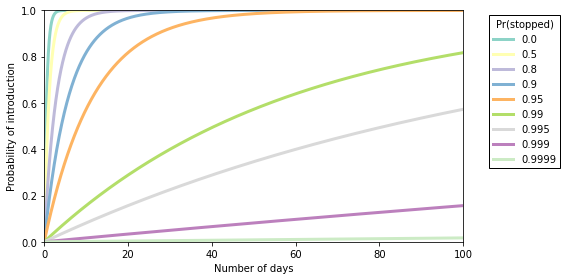

In [5]:
cmp = plt.cm.get_cmap('Set3', lq+1)
plt.figure(figsize=(8,4))
for i, q in enumerate(qran):
    plt.plot(tran, Fmat[i,:], label=str(q), lw=3, c=cmp(i))
plt.xlabel('Number of days')
plt.ylabel('Probability of introduction')
plt.legend(title='Pr(stopped)', loc=2, bbox_to_anchor=(1.05, 1), framealpha=1., edgecolor='black', fancybox=False)
plt.xlim([0,100])
plt.ylim([0,1])
plt.tight_layout()
plt.savefig('./TeX/var_F.pdf')

## Second experiment: international doubling

In [6]:
def myq(tD,dtau):
    return (1. - np.exp(-(dtau/tD)*np.log(2)))

In [7]:
dtran = np.array([1., 7., 14., 28., 60., 100.])
tDran = np.arange(0,30.1,0.1)
ld = len(dtran)
lt = len(tDran)
qmat = np.zeros((ld,lt))
for i, d in enumerate(dtran):
    for j, t in enumerate(tDran):
        qmat[i,j] = myq(t,d)

<ipython-input-6-13cb713a5527>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return (1. - np.exp(-(dtau/tD)*np.log(2)))


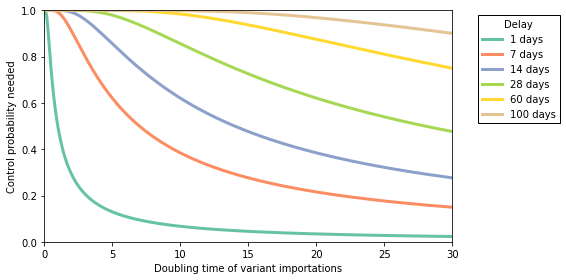

In [8]:
cmp = plt.cm.get_cmap('Set2', ld+1)
plt.figure(figsize=(8,4))
for i, d in enumerate(dtran):
    plt.plot(tDran,qmat[i,:],label= str(int(d)) + ' days',c=cmp(i),lw=3)
plt.xlim((np.min(tDran),np.max(tDran)))
plt.ylim((0,1))
plt.legend(title='Delay', loc=2, bbox_to_anchor=(1.05, 1), framealpha=1., edgecolor='black', fancybox=False)
plt.xlabel('Doubling time of variant importations')
plt.ylabel('Control probability needed')
plt.tight_layout()
plt.savefig('./TeX/var_q.pdf')

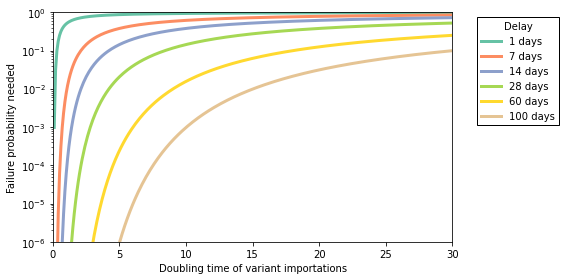

In [9]:
plt.figure(figsize=(8,4))
for i, d in enumerate(dtran):
    plt.plot(tDran[1:],1.-qmat[i,1:],label= str(int(d)) + ' days',c=cmp(i),lw=3)
plt.xlim((np.min(tDran),np.max(tDran)))
plt.yscale('log')
plt.legend(title='Delay', loc=2, bbox_to_anchor=(1.05, 1), framealpha=1., edgecolor='black', fancybox=False)
plt.xlabel('Doubling time of variant importations')
plt.ylabel('Failure probability needed')
plt.ylim([1e-6,1.])
plt.tight_layout()
plt.savefig('./TeX/var_q_log.pdf')

## Third experiment: q(t)

In [10]:
# =============================================================================
# Class for solving ODEs
# =============================================================================

class ODESolver:
    def __init__(self, f):
        self.f = f
    
    def advance(self):
        raise NotImplementedError
    
    def set_ic(self, u0):
        if not isinstance(u0, float):
            self.u0 = u0.astype(float)
        else:
            self.u0 = u0
    
    def solver(self, time_points):
        self.t = np.asarray(time_points)
        self.tlen = len(self.t)
        self.numeqs = np.shape(self.u0)[0]
        self.u = np.zeros((self.numeqs, self.tlen))
        self.u[:,0] = self.u0
        for k in range(0,self.tlen-1):
            self.k=k
            self.u[:, k+1] = self.advance()
        return self.u, self.t
    
class ForwardEuler(ODESolver): # Runs faster than Runge Kutta
    def advance(self):
        u, f, k, t = self.u, self.f, self.k, self.t
        dt = t[k+1] - t[k]
        unew = u[:, k] + dt*f(u[:, k], t[k])
        return unew

class RungeKutta4(ODESolver): # Alternatively, can use Runge Kutta (may be preferable to Euler if inhomogeneous rates are particularly pathological)
    def advance(self):
        u, f, k, t = self.u, self.f, self.k, self.t
        numeqs = np.shape(u)[0]
        dt = t[k+1]-t[k]
        dt2 = dt/2.0
        unew = np.zeros(numeqs)
        
        K1 = dt*f(u[:, k], t[k])
        K2 = dt*f(u[:, k] + 0.5*K1, t[k]+dt2)
        K3 = dt*f(u[:, k] + 0.5*K2, t[k] + dt2)
        K4 = dt*f(u[:, k] + K3, t[k] + dt)
    
        unew = u[:, k] + (1/6.0)*(K1 + 2*K2 + 2*K3 + K4)
        return unew

In [12]:
# =============================================================================
# Class for extinction probability of multi-type branching process (MTBP)
# =============================================================================

class MTBP_extinct:
    def __init__(self, offspring):
        self.offspring = offspring
    def set_lifespans(self, omega):
        self.omega = omega
    def set_immigration(self, eta):
        
        self.eta = eta
    
    def set_odes(self, u, t):
        omega = self.omega
        P = self.offspring
        eta = self.eta
        if isinstance(eta(t), float):
            self.numeqs=1
            deriv = np.zeros(self.numeqs + 1)
            deriv[0] = -omega(t)*u[0] + omega(t)*P(u[0:-1], t)[0]
            sumqs = eta(t)*u[0]
            deriv[-1] = -np.sum(eta(t))*u[-1] + u[-1]*sumqs
        else:
            self.numeqs = len(eta(t))
            sumqs = 0
            deriv = np.zeros(self.numeqs + 1)
            for i in range(0, self.numeqs):
                deriv[i] = -omega(t)[i]*u[i] + omega(t)[i]*P(u[0:-1], t)[i]

                sumqs += eta(t)[i]*u[i]

            deriv[-1] = -np.sum(eta(t))*u[-1] + u[-1]*sumqs

        return deriv

    def solve_odes(self, set_odes, t, ics, n0, methodclass=RungeKutta4, Full = False):
        method = methodclass(set_odes)
        method.set_ic(u0=ics)
        R, t = method.solver(time_points=t)
        numqs = np.shape(R)[0] - 1
        tlen = len(t)
        Qprod = np.ones(tlen)
        r = R[-1,:]
        if isinstance(n0, float):
            for i in range(0, numqs):
                Qprod *= R[i,:]**(n0)
        else:
            for i in range(0, numqs):
                Qprod *= R[i,:]**(n0[i])
        rho = r*Qprod
        sol = np.stack((Qprod, rho), axis=0)
        if Full:
            return R
        else:
            return sol
    
    def time_to_pextinct(self, t, p, sol):
        rho = sol[-1,:]
        numqs = np.shape(sol)[0] - 1
        q = np.ones_like(rho)
        for i in range(0, numqs):
            q*=sol[i, :]
        if isinstance(p, float):
            qwhere = np.where(q>=p)[0]
            rhowhere = np.where(rho>=p)[0]
            if len(qwhere)>0:
                qmin = np.min(t[np.where(q>=p)])
            else:
                qmin = np.inf
            if (len(rhowhere)>0) and (rho[-1]>=p):
                rhomin = np.min(t[np.where(rho>=p)])
            else:
                rhomin =  np.inf
            return np.array((qmin, rhomin))
        elif len(p)>1:
            qmin = np.zeros_like(p)
            rhomin = np.zeros_like(p)
            extinct_times = np.zeros((len(p), 2)) 
            for j in range(0, len(p)):
                qwhere = np.where(q>=p[j])[0]
                rhowhere = np.where(rho>=p[j])[0]
                if len(qwhere)>0:
                    qmin[j] = np.min(t[np.where(q>=p[j])])
                else:
                    qmin[j] = np.inf
                if (len(rhowhere)>0) and (rho[-1]>=p[j]):
                    rhomin[j] = np.min(t[np.where(rho>=p[j])])
                else:
                    rhomin[j] =  np.inf
            extinct_times[:,0] = qmin
            extinct_times[:,1] = rhomin
            return(extinct_times)
    
    def qr_final(self, sol):
        sol = sol[-1,:]
        q_final = np.prod(sol[0:-1,-1])
        rho_final = sol[-1, -1]
        return [q_final, rho_final]

In [13]:
time = np.arange(0, 100, 0.01)
gam = 1/7 # seven day infectious period
Tmax = time[-1]
Rvec = np.array([0.5, 1.0, 1.5, 2., 4.])
kvec = np.array((-1., 0.1, 1.)) # Different dispersion parameters for NB - large k corresponds to Poisson distribution.
cran = np.arange(0., 1.01, 0.01) # Reduction in transmission (beta) or, equivalently, in R
lk = len(kvec) 
# cran = np.array((0, 1))
lc = len(cran)
k = 1/10
lr = len(Rvec)
def eta(t):
    return float(1/50.) # Immigration rate

n0 = 1.
ics = np.array((0., 1.)) # Should always be 0 for q, 1 for r
rho_mat = np.zeros((lk, lr, len(time)))
for k, K in enumerate(kvec):
    for r, R in enumerate(Rvec):
        beta = R*gam
        def omega(t):
            return beta + gam
        
        def P(u, t):
            p = (beta/(beta+gam))*(np.power((1 + (1/K)*(1-u)), -K))*u + gam/(beta+gam)
            return p

        offspring = P
        outbreak = MTBP_extinct(offspring)
        outbreak.set_lifespans(omega)
        outbreak.set_immigration(eta)

        rho = outbreak.solve_odes(outbreak.set_odes, time, ics, n0)
        rho_mat[k, r, :] = rho[0,:] 


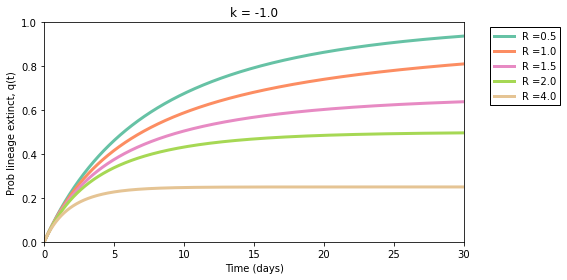

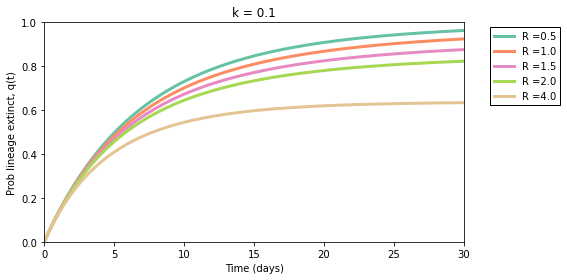

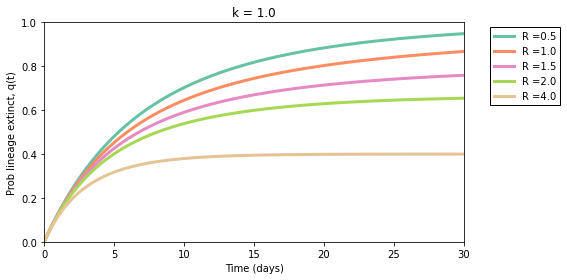

In [14]:
cmp = plt.cm.get_cmap('Set2', len(Rvec)+1)
for k in range(0, len(kvec)):
    plt.figure(figsize=(8,4))
    for r in range(0, len(Rvec)):
        plt.plot(time, rho_mat[k, r, :], label='R ='+ str(Rvec[r]), lw = 3,c=cmp(r))
    plt.title('k = ' + str(kvec[k]))
    plt.xlim([0,30])
    plt.ylim([0,1])
    plt.legend(loc=2, bbox_to_anchor=(1.05, 1), framealpha=1., edgecolor='black', fancybox=False)
    plt.xlabel('Time (days)')
    plt.ylabel('Prob lineage extinct, q(t)')
    plt.tight_layout()
    plt.savefig('./TeX/q_t_k' + str(kvec[k]) + '.pdf')